# Efficient Influence Function (EIF), Causal Forest DML and Continuous Treatment, & DML with Mediator and Continuous Treatment

Daniel de Abreu Pereira Uhr

### Tópicos abordados nesta aula:

* Efficient Influence Function (EIF)
* Causal Forest DML and Continuous Treatment
* DML with Mediator and Continuous Treatment


**Observações:** O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer *feedback* ou sugestão de melhoria.

---

## Efficient Influence Function (EIF)


A **Efficient Influence Function (EIF)** (ou **Função de Influência Eficiente**) é o **objeto matemático fundamental** que define:

1. o **estimador mais eficiente possível** de um parâmetro causal (como o ATE),
2. e as condições sob as quais esse estimador é **sem viés em primeira ordem** mesmo quando usamos ML flexível nas etapas auxiliares.

Quando queremos estimar um parâmetro causal, por exemplo o efeito médio do tratamento (ATE):

$$
\psi_0 = E[m_1(X) - m_0(X)]
$$

onde ($m_d(X) = E[Y|D=d, X]$),

temos duas fontes de incerteza:

* o erro de amostragem (ruído estatístico);
* e o erro de estimação dos “nuisance functions” (os modelos de ($E[Y|D,X]$) e ($P(D|X)$)).


**Definição**

A **Efficient Influence Function (EIF)** é uma função ($\phi(W; \psi_0)$) que mede **como o erro em cada observação influencia o erro total do estimador** de forma linearizada.

Considere o espaço de todas as distribuições ($P$) para os dados ($W=(Y,D,X)$). O parâmetro de interesse é uma função ($\psi(P)$) (por exemplo, o ATE).

A **influence function** (IF) é definida como:

$$
\phi(W; P) = \left. \frac{d}{d\epsilon} \psi(P_\epsilon) \right|_{\epsilon=0}
$$

onde ($P_\epsilon = (1 - \epsilon) P + \epsilon \delta_W$).

***Interpretação:***

É a **sensibilidade infinitesimal** do estimando ($\psi(P)$) a pequenas perturbações na distribuição amostral em torno de ($P$).

A **Efficient Influence Function (EIF)** é a **influence function com menor variância** entre todas as IFs válidas (isto é, todas que têm esperança zero e derivam corretamente ($\psi(P)$)).
Essa variância mínima define o **semiparametric efficiency bound**.

**Exemplo**

Para ($D \in {0,1}$), o EIF do ATE é:

$$
\phi(W; \eta) =
\left[
\frac{D}{p(X)} - \frac{1-D}{1-p(X)}
\right](Y - m(D,X)) + [m(1,X) - m(0,X)] - \psi
$$

onde:

* ($p(X) = P(D=1|X)$) é o propensity score,
* ($m(d,X) = E[Y|D=d, X]$) é o outcome regression,
* ($\eta = (m, p)$) é o vetor dos “nuisance parameters”.

Esse objeto é importante porque:

* ($E[\phi(W; \eta_0)] = 0$) no ponto verdadeiro;
* Ele é **ortogonal**: pequenas variações em ($m$) ou ($p$) não alteram ($\psi$) em primeira ordem;
* E ele **gera todos os estimadores eficientes** possíveis (TMLE, AIPW, DR-DML, etc).

A EIF serve como a **base de construção** de todos os estimadores modernos de efeito causal:

| Estimador                | Como usa a EIF                                                            |
| ------------------------ | ------------------------------------------------------------------------- |
| **AIPW (Augmented IPW)** | Substitui ($m, p$) por ML e usa a média de ($\phi(W; \hat\eta)$)              |
| **TMLE**                 | Ajusta ($m$) até que a média de ($\phi(W; \hat\eta^*) = 0$)                   |
| **DR-DML**               | Usa cross-fitting e estima ($\psi$) resolvendo ($E_n[\phi(W; \hat\eta)] = 0$) |
| **Causal Forests**       | Aproximam o EIF localmente em cada folha                                  |
| **G-formula**            | Implícita, sem ajuste pela EIF (por isso é menos robusta)                 |


***Propriedades***

1. **Esperança zero:**
   $$
   E[\phi(W; \eta_0)] = 0
   $$

2. **Ortogonalidade:**
   $$
   \frac{\partial E[\phi(W; \eta)]}{\partial \eta}\Big|_{\eta_0} = 0
   $$
   → pequenos erros em ML não afetam ($\hat\psi$).

3. **Variância mínima:**
   $$
   Var(\phi(W; \eta_0)) = \text{Semiparametric Efficiency Bound}
   $$

4. **Inferência assintótica:**
   $$
   \sqrt{n}(\hat\psi - \psi_0) \to N(0, Var(\phi(W; \eta_0)))
   $$
   → Intervalos de confiança vêm diretamente da EIF.

***Relação entre TMLE, DR e DML***

* **TMLE**: constrói um modelo para ($m(D,X)$) e ajusta via *targeting* até satisfazer ($E_n[\phi(W;\hat\eta)] = 0$).
* **DR-DML**: usa cross-fitting e resolve a mesma equação, mas sem targeting iterativo.
* **Ambos estimam o mesmo parâmetro** — o ATE — definido exatamente pela EIF acima.


***Interpretação intuitiva***

Pense na EIF como o **"peso ótimo"** que cada observação deve ter para corrigir viés de confusão.

* O termo ($\frac{D}{p(X)} - \frac{1-D}{1-p(X)}$) ajusta o desequilíbrio de propensão;
* O termo ($Y - m(D,X)$) corrige a predição;
* E ($m(1,X) - m(0,X)$) dá o componente contrafactual esperado.

A média ponderada desses componentes é o **efeito causal eficiente**.

## Causal Forest DML and Continuous Treatment



Causal Forests são uma extensão das Random Forests para estimar efeitos causais heterogêneos.

In [40]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns

# DataFrame
df = pd.read_stata("https://github.com/Daniel-Uhr/data/raw/main/cattaneo2.dta")

In [43]:
# Criar a variável de resultado
df['Y'] = df['bweight']

# Crie a variável 'Treated' com valor inicial de 0
df['Treated'] = 0
# Recodifique 'Treated' para 1 se 'mbsmoke' for igual a 'smoker'
df.loc[df['mbsmoke'] == 'smoker', 'Treated'] = 1

df['casada'] = 0
df.loc[df['mmarried']=='married', 'casada'] = 1

# Conjunto de Covariáveis X
X = ['casada', 'mage', 'medu']

# garanta a ordem correta das categorias (se necessário)
order = ['0 daily', '1-5 daily', '6-10 daily', '11+ daily']
df['msmoke'] = pd.Categorical(df['msmoke'], categories=order, ordered=True)

# mapeamentos
map_mid = {
    '0 daily': 0,
    '1-5 daily': 3,
    '6-10 daily': 8,
    '11+ daily': 12  # ajuste se quiser um outro representativo (ex.: 15)
}
map_ord = {k: i for i, k in enumerate(order)}  # 0,1,2,3 (ordinal)

# variáveis de tratamento
df['T_cont'] = df['msmoke'].map(map_mid).astype(float) 

c:\Users\danie\OneDrive\python\.venv-dmlmed\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


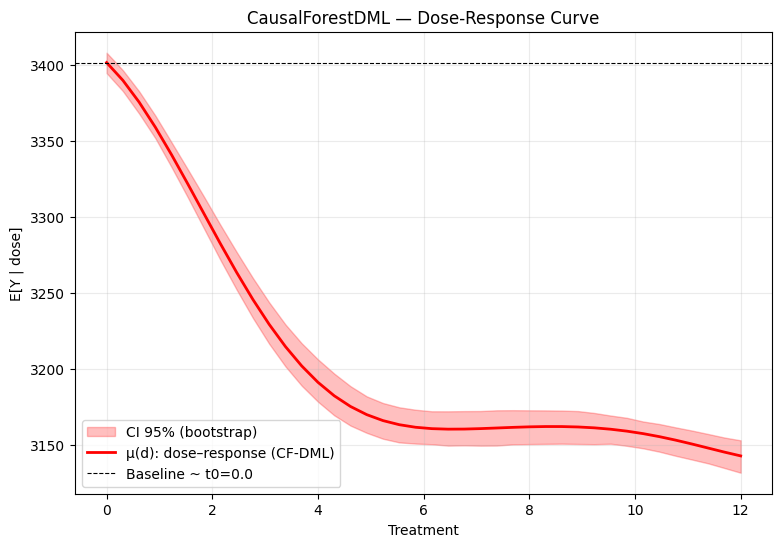

In [44]:
# ==========================================================
# CausalForestDML — Dose–resposta com IC (vermelho),
# Nível = E[Y|t0,X] (modelo de outcome) + efeito CF (t0->t)
# Grid; RBF features; bootstrap nas unidades X
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
from econml.dml import CausalForestDML

# ---------- Config ----------
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)

# ---------- 0) Dados ----------
try:
    df
except NameError:
    df = pd.read_stata("https://github.com/Daniel-Uhr/data/raw/main/cattaneo2.dta")
    df['Y'] = df['bweight']
    df['casada'] = (df['mmarried'] == 'married').astype(int)

# Use o T_cont contínuo que você já criou (sem jitter), ou crie mapeamento midpoints
# Aqui assumo que df['T_cont'] já existe (se não, crie como no seu TMLE).
df_ = df[['Y','T_cont','casada','mage','medu']].dropna().copy()

Y = df_['Y'].to_numpy(dtype=np.float32)
T = df_['T_cont'].to_numpy(dtype=np.float32)
X = df_[['casada','mage','medu']].to_numpy(dtype=np.float32)

Xn = StandardScaler().fit_transform(X).astype(np.float32)

# ---------- 1) Featurizador em T: RBF (mais rico → curva menos "quadrática") ----------
tfeat = RBFSampler(gamma=0.08, n_components=150, random_state=RNG_SEED)

# ---------- 2) Nuisance models (um pouco mais fortes, ainda rápidos) ----------
rf_cfg = dict(
    n_estimators=120,
    max_depth=10,
    min_samples_leaf=15,
    max_features='sqrt',
    n_jobs=-1,
    random_state=RNG_SEED
)
model_y = ExtraTreesRegressor(**rf_cfg)
model_t = ExtraTreesRegressor(**rf_cfg)

# ---------- 3) CausalForestDML ----------
cf = CausalForestDML(
    model_y=model_y,
    model_t=model_t,
    treatment_featurizer=tfeat,
    discrete_treatment=False,
    n_estimators=300,
    min_samples_leaf=10,
    max_depth=8,
    random_state=RNG_SEED,
    n_jobs=-1,
    verbose=0
)
# T em 2D por causa do featurizer
cf.fit(Y, T.reshape(-1, 1), X=Xn)

# ---------- 4) Modelo de outcome para o NÍVEL E[Y|t0, X]
# Usamos a MESMA featurização de T do CF para coerência
# Feature final: concatena Xn com phi(T) (RBF transform)
Phi_T = tfeat.fit_transform(T.reshape(-1, 1))  # usa a mesma instância tfeat
Z = np.hstack([Xn, Phi_T])                     # regressão Y ~ X + phi(T)

outcome_model = clone(model_y)
outcome_model.fit(Z, Y)

def predict_y_at_t(Xblock, t_scalar):
    # constroi features [X, phi(t)] p/ cada linha de Xblock
    m = Xblock.shape[0]
    Phi = tfeat.transform(np.full((m, 1), t_scalar, dtype=np.float32))
    Zt = np.hstack([Xblock, Phi])
    return outcome_model.predict(Zt)

# ---------- 5) Curva dose–resposta + IC (bootstrap nas unidades X)
# amostra maior de X para agregação
M = min(600, len(Xn))
idx = rng.choice(len(Xn), size=M, replace=False)
Xsub = Xn[idx]

# grid de 40 doses
t_min, t_max = float(np.nanmin(T)), float(np.nanmax(T))
G = 40
t_grid = np.linspace(t_min, t_max, G).astype(np.float32)

# baseline: percentil 5% (na região com dados)
t0 = float(np.percentile(T, 5))

# 5.1) Nível no baseline por unidade: Y_hat(t0|X)
y0_hat = predict_y_at_t(Xsub, t0)  # (M,)

# 5.2) Efeito marginal CF por unidade para cada t do grid
Eff = np.empty((G, M), dtype=np.float32)
for g, t1 in enumerate(t_grid):
    T0 = np.full((M, 1), t0, dtype=np.float32)
    T1 = np.full((M, 1), t1, dtype=np.float32)
    Eff[g, :] = cf.effect(Xsub, T0=T0, T1=T1)  # τ(X; t0→t1)

# 5.3) Reconstrução do nível e média por dose
# μ(d) = mean_X [ Y_hat(t0|X) + τ(X; t0→d) ]
mu_hat = (y0_hat[None, :] + Eff).mean(axis=1)  # (G,)

# 5.4) Bootstrap das unidades X (rápido, sem refitar o CF)
B = 300
boot_mu = np.empty((B, G), dtype=np.float32)
for b in range(B):
    samp = rng.integers(0, M, size=M)  # reamostra unidades
    boot_mu[b, :] = (y0_hat[samp][None, :] + Eff[:, samp]).mean(axis=1)

alpha = 0.05
lo = np.percentile(boot_mu, 100*(alpha/2), axis=0)
hi = np.percentile(boot_mu, 100*(1-alpha/2), axis=0)

# ---------- 6) Plot (vermelho) ----------
plt.figure(figsize=(9,6))
plt.fill_between(t_grid, lo, hi, color='red', alpha=0.25, label='CI 95% (bootstrap)')
plt.plot(t_grid, mu_hat, color='red', lw=2, label='μ(d): dose–response (CF-DML)')
plt.axhline(mu_hat[np.argmin(np.abs(t_grid - t0))], color='k', ls='--', lw=0.8, label=f'Baseline ~ t0={t0:.1f}')
plt.xlabel("Treatment")
plt.ylabel("E[Y | dose]")
plt.title("CausalForestDML — Dose-Response Curve")
plt.legend()
plt.grid(True, alpha=0.25)
plt.show()

***CATE***

Comparando curvas CATE, para perfil/status diferente

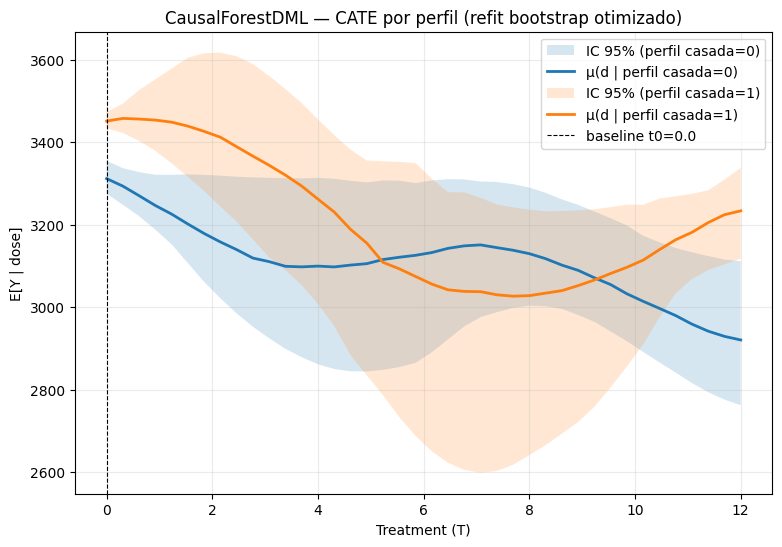

In [51]:
# ==========================================================
# CATE (por perfil) — CF + baseline outcome
# Refit bootstrap MULTI-perfil, economizando memória (float32)
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.kernel_approximation import RBFSampler

# -----------------------------
# 0) Pré-requisitos mínimos
# -----------------------------
assert 'df_' in globals(), "df_ não encontrado."
assert 'COLS_X' in globals(), "Defina COLS_X (ordem das covariáveis)."
assert 'T' in globals(), "T (tratamento) não encontrado."
assert 'outcome_model' in globals(), "outcome_model não encontrado (do ajuste original)."
assert 'tfeat' in globals(), "tfeat não encontrado (do ajuste original)."

if 'scaler' not in globals():
    scaler = StandardScaler().fit(df_[COLS_X].astype(float))

# -----------------------------
# Helpers
# -----------------------------
def _resolve_control_value(series: pd.Series, spec):
    if isinstance(spec, (int, float, np.number)):
        return float(spec)
    if isinstance(spec, str):
        s = spec.strip().lower()
        if s == "mean":   return float(series.mean())
        if s == "median": return float(series.median())
        if s.startswith("p"):
            q = float(s[1:])
            return float(np.percentile(series.to_numpy(dtype=float), q))
    raise ValueError(f"Especificação inválida: {spec}")

def make_controlled_profile(df_base: pd.DataFrame, cols_x, control_spec: dict):
    return {c: _resolve_control_value(df_base[c], control_spec.get(c, "mean")) for c in cols_x}

def to_vec(profile: dict, cols_x):
    return np.array([profile[c] for c in cols_x], dtype=np.float32).reshape(1, -1)

# -----------------------------
# 1) Predição de nível no baseline (usa outcome_model/tfeat do ajuste original)
# -----------------------------
def predict_y_at_t(Xblock_scaled, t_scalar):
    m = Xblock_scaled.shape[0]
    Phi = tfeat.transform(np.full((m, 1), t_scalar, dtype=np.float32))
    Zt  = np.hstack([Xblock_scaled, Phi])
    return outcome_model.predict(Zt)

# -----------------------------
# 2) Bootstrap com REFIT (multi-perfil) — otimizado p/ memória
# -----------------------------
def cate_curves_refit_multi(df_base, cols_x, y_col, t_col,
                            profiles: dict,  # {"A": dict, "B": dict, ...}
                            t_grid, t0,
                            B=100, alpha=0.05, rng_seed=123,
                            rbf_gamma=0.08, rbf_comp=30,
                            cf_params=None, rf_cfg=None):
    """
    Retorna dict com {key: (mu_hat, lo, hi)} para cada perfil em 'profiles'.
    Refita CF/outcome em cada réplica e computa TODAS as curvas de uma vez.
    """
    from econml.dml import CausalForestDML
    rng = np.random.default_rng(rng_seed)

    # ExtraTrees mais parcimonioso e n_jobs=1 para evitar pico de RAM
    if rf_cfg is None:
        rf_cfg = dict(n_estimators=120, max_depth=6, min_samples_leaf=25,
                      max_features='sqrt', n_jobs=1, random_state=42)
    # Hiperparâmetros do CF **válidos** no CausalForestDML
    if cf_params is None:
        cf_params = dict(
            n_estimators=120,
            min_samples_leaf=25,
            max_depth=6,
            max_features=0.5,      # fração de features por split
            subforest_size=40,     # agrega em blocos para reduzir memória
            honest=True,
            n_jobs=1,              # evita paralelo pesado em RAM
            verbose=0,
            random_state=42,
            discrete_treatment=False
        )

    # Dados base em float32
    dfb = df_base[cols_x + [y_col, t_col]].dropna().copy()
    X_all = dfb[cols_x].to_numpy(dtype=np.float32)
    Y_all = dfb[y_col].to_numpy(dtype=np.float32)
    T_all = dfb[t_col].to_numpy(dtype=np.float32).reshape(-1, 1)

    n = len(Y_all)
    G = len(t_grid)
    boot_store = {k: np.empty((B, G), dtype=np.float32) for k in profiles.keys()}

    for b in range(B):
        idx = rng.integers(0, n, size=n)
        Xb = X_all[idx].astype(np.float32, copy=False)
        Yb = Y_all[idx].astype(np.float32, copy=False)
        Tb = T_all[idx].astype(np.float32, copy=False)

        scaler_b = StandardScaler().fit(Xb)
        Xbn = scaler_b.transform(Xb).astype(np.float32, copy=False)

        # Featurizer RBF: fit + transform (leve)
        tfeat_b = RBFSampler(gamma=rbf_gamma, n_components=rbf_comp, random_state=42)
        tfeat_b.fit(Tb)
        Phi_Tb = tfeat_b.transform(Tb).astype(np.float32, copy=False)

        # Nuisances
        model_y_b = ExtraTreesRegressor(**rf_cfg)
        model_t_b = ExtraTreesRegressor(**rf_cfg)

        # CF com featurizer (sem subsample_fr)
        cf_b = CausalForestDML(model_y=model_y_b, model_t=model_t_b,
                               treatment_featurizer=tfeat_b, **cf_params)
        cf_b.fit(Yb, Tb, X=Xbn)

        # Modelo de nível com o mesmo φ(T)
        Zb = np.hstack([Xbn, Phi_Tb]).astype(np.float32, copy=False)
        outcome_model_b = ExtraTreesRegressor(**rf_cfg).fit(Zb, Yb)

        def predict_y_at_t_b(Xblock_scaled, t_scalar):
            m = Xblock_scaled.shape[0]
            Phi = tfeat_b.transform(np.full((m, 1), t_scalar, dtype=np.float32))
            Zt  = np.hstack([Xblock_scaled, Phi]).astype(np.float32, copy=False)
            return outcome_model_b.predict(Zt)

        # Perfis desta réplica
        x0s_dict = {}
        y0_dict  = {}
        for k, prof in profiles.items():
            x0  = to_vec(prof, cols_x)
            x0s = scaler_b.transform(x0.astype(np.float32)).astype(np.float32, copy=False)
            x0s_dict[k] = x0s
            y0_dict[k]  = float(predict_y_at_t_b(x0s, t0)[0])

        # Curvas
        for j, t1 in enumerate(t_grid):
            T0 = np.array([[t0]], dtype=np.float32)
            T1 = np.array([[t1]], dtype=np.float32)
            for k in profiles.keys():
                eff = float(cf_b.effect(x0s_dict[k], T0=T0, T1=T1)[0])
                boot_store[k][b, j] = y0_dict[k] + eff

    out = {}
    for k in profiles.keys():
        mu_hat = np.median(boot_store[k], axis=0)
        lo = np.percentile(boot_store[k], 100*(alpha/2), axis=0)
        hi = np.percentile(boot_store[k], 100*(1-alpha/2), axis=0)
        out[k] = (mu_hat, lo, hi)
    return out

# -----------------------------
# 3) Perfis e grid
# -----------------------------
CONTROL_SPEC_BASE = {'casada': 'mean', 'mage': 'mean', 'medu': 'mean'}
ctrl_base = make_controlled_profile(df_[COLS_X], COLS_X, CONTROL_SPEC_BASE)
perfil_A  = {**ctrl_base, 'casada': 0}
perfil_B  = {**ctrl_base, 'casada': 1}

if 't_grid' not in globals():
    t_lo, t_hi = np.quantile(T, [0.02, 0.98])
    t_grid = np.linspace(float(t_lo), float(t_hi), 30, dtype=np.float32)  # 30 pts
if 't0' not in globals():
    t0 = float(np.quantile(T, 0.05))

profiles = {"A": perfil_A, "B": perfil_B}

# -----------------------------
# 4) Rodar (B pequeno para RAM; aumente se couber)
# -----------------------------
alpha = 0.05
res = cate_curves_refit_multi(df_base=df_, cols_x=COLS_X,
                              y_col='Y', t_col='T_cont',
                              profiles=profiles, t_grid=t_grid, t0=t0,
                              B=100, alpha=alpha, rng_seed=123,
                              rbf_gamma=0.08, rbf_comp=30)

mu_A, lo_A, hi_A = res["A"]
mu_B, lo_B, hi_B = res["B"]

# -----------------------------
# 5) Plot
# -----------------------------
plt.figure(figsize=(9,6))
plt.fill_between(t_grid, lo_A, hi_A, alpha=0.18, label='IC 95% (perfil casada=0)')
plt.plot(t_grid, mu_A, lw=2, label='μ(d | perfil casada=0)')
plt.fill_between(t_grid, lo_B, hi_B, alpha=0.18, label='IC 95% (perfil casada=1)')
plt.plot(t_grid, mu_B, lw=2, label='μ(d | perfil casada=1)')
plt.axvline(t0, color='k', ls='--', lw=0.8, label=f'baseline t0={t0:.1f}')
plt.xlabel("Treatment (T)")
plt.ylabel("E[Y | dose]")
plt.title("CausalForestDML — CATE por perfil (refit bootstrap otimizado)")
plt.grid(True, alpha=0.25); plt.legend(); plt.show()


## DML with Mediator and Continuous Treatment

Double Machine Learning + Kernel Mean Embedding

KME permite:

* estimar não-linearidade sem especificar forma (sem polinômios)
*  aproximar distribuições condicionais
*  suavidade controlada por bandwidth
*  convergência teórica


Parecido com Causal Forests, mas em RKHS (a expectativa é no espaço de reproducing kernel Hilbert spaces - RKHS):
* ao invés de pesos de árvore
* temos pesos kernel

In [52]:
%cd "C:/Users/danie/OneDrive/python/double-debiased-machine-learning-mediation-continuous-treatments"
import os
os.getcwd()

C:\Users\danie\OneDrive\python\double-debiased-machine-learning-mediation-continuous-treatments


'C:\\Users\\danie\\OneDrive\\python\\double-debiased-machine-learning-mediation-continuous-treatments'

Carregando o data-frame do artigo:

In [53]:
import numpy as np
import pandas as pd
from data.uniform import UniformEnv

# 1) data_settings iguais aos dos scripts
data_settings = {
    'expname': 'debug',
    'data': 'uniform',
    'n_samples': 2000,
    'mediator_dimension': 1,
    'covariate_dimension': 1,
    'alpha': 0.5,
    'beta': 0.25,
    'stochasticity': 1.0,
    'gamma': 0.3,
    'noise': 'uniform',
}

# 2) instanciar o ambiente
env = UniformEnv(data_settings)

# 3) CHAMADA EXPLÍCITA: params=None e mode='train'
x, t, m, y, params = env.generate_causal_data(
    data_settings,
    params=None,
    random_state=42,
    mode='train',        # <- força o ramo que cria X
)

# 4) converter para DataFrame
df = pd.DataFrame({
    'X1': x[:, 0],
    'T': t.squeeze(),
    'M': m[:, 0] if m.ndim > 1 else m,
    'Y': y.squeeze(),
})

Estimando efeito direto e indireto com tratamento contínuo usando DML conforme o artigo.

In [55]:
# ========= Mediation DML Driver (flexível p/ múltiplas mediadoras) =========
import os, numpy as np, pandas as pd
os.environ["OMP_NUM_THREADS"]="1"
os.environ["MKL_NUM_THREADS"]="1"
os.environ["OPENBLAS_NUM_THREADS"]="1"
np.random.seed(42)

# ----- estimadores do repositório -----
from estimators.kme_dml import KMEDoubleMachineLearning
from estimators.sani_kme_dml import SaniKMEDoubleMachineLearning
from estimators.sani_dml import SaniDoubleMachineLearning
from estimators.ipw import ImportanceWeighting
from estimators.linear import Linear
from estimators.kme_g_computation import KMEGComputation

# ======== 1) CABEÇALHO (EDITE AQUI) ========
CONFIG = dict(
    dataset_name = "meu_dataset",
    treatment    = "T",                      # coluna do tratamento contínuo
    mediators    = ["M"],   # 1+ mediadoras
    covariates   = ["X1"],        # 0+ covariáveis
    outcome      = "Y",                      # coluna do resultado
    doses        = None,                     # ex.: (d, d_prime) ou None p/ usar quantis
    dose_quantiles = (0.25, 0.75),          # usados se doses=None
    direct_mode  = "free",                   # "free" | "none" | "auto"
    bootstrap_B  = 0,                      # 0 = não faz; >0 faz bootstrap p/ direto/indireto
    alpha        = 0.05,                     # nível dos ICs
    settings_base = dict(                    # presets “científicos” do paper
        regularization=True,
        sample_splits=2,
        reg_lambda=1e-3,
        reg_lambda_tilde=1e-3,
        kernel='gauss',
        density='ls_conditional',            # ou 'conditional_kernel'
        bandwidth=0.5,
        bandwidth_mode='amse',
        epsilon=0.2,
        normalized=True,
        random_seed=42,
    ),
    model_overrides = { "IPW": {"density":"gaussian"} },  # tunagens por modelo (opcional)
    models = [                               # quais modelos rodar
        ("OLS_linear", Linear),
        ("IPW", ImportanceWeighting),
        ("KME_Gcomp", KMEGComputation),
        ("DML_KME", KMEDoubleMachineLearning),
        ("Sani_DML", SaniDoubleMachineLearning),
        ("Sani_KME_DML", SaniKMEDoubleMachineLearning),
    ],
)

# ======== 2) Funções utilitárias ========
def _to2d(a):
    a = np.asarray(a, float)
    return a.reshape(-1,1) if a.ndim==1 else a

def _pick_doses(df, tname, doses, dose_quantiles):
    if doses is not None:
        d, dp = map(float, doses);  return d, dp
    q = df[tname].quantile
    return float(q(dose_quantiles[0])), float(q(dose_quantiles[1]))

def _ic_from_variance(total, var, me, z=1.96):
    if pd.notna(me) and me>0:
        se = me / z
    elif pd.notna(var) and var>0:
        se = float(np.sqrt(var))
    else:
        return np.nan, np.nan, np.nan
    return se, total - z*se, total + z*se

def _sig_flag(lo, hi):
    return int(pd.notna(lo) and pd.notna(hi) and (lo*hi > 0))

def _bootstrap_ci(est_cls, settings, T,M,X,Y, d,dp, B=200, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    n = len(Y)
    # ponto
    e0 = est_cls(settings, False); e0.fit(T,M,X,Y)
    out0 = e0.estimate(d,dp,T,M,X,Y)
    totals, directs, indirects = [], [], []
    for _ in range(B):
        idx = rng.integers(0, n, n)
        Tb,Mb,Xb,Yb = T[idx], M[idx], X[idx], Y[idx]
        eb = est_cls(settings, False); eb.fit(Tb,Mb,Xb,Yb)
        ob = eb.estimate(d,dp,Tb,Mb,Xb,Yb)
        totals.append(ob['total_effect'])
        directs.append(ob['direct_effect'])
        indirects.append(ob['indirect_effect'])
    def S(v):
        v = np.asarray(v,float)
        se = v.std(ddof=1)
        lo,hi = np.quantile(v, [alpha/2, 1-alpha/2])
        return se, lo, hi
    return dict(point=out0, total=S(totals), direct=S(directs), indirect=S(indirects))

# ======== 3) Driver principal ========
def run_mediation_driver(df: pd.DataFrame, cfg: dict = CONFIG) -> pd.DataFrame:
    # --- prepara dados conforme cabeçalho ---
    tname, mnames, xnames, yname = cfg["treatment"], cfg["mediators"], cfg["covariates"], cfg["outcome"]
    assert all(c in df.columns for c in [tname, yname]), "Tratamento/resultado ausentes no DataFrame."
    assert all(c in df.columns for c in mnames), "Alguma mediadora indicada não está no DataFrame."
    if xnames:
        assert all(c in df.columns for c in xnames), "Alguma covariável indicada não está no DataFrame."

    T = df[tname].to_numpy(float).ravel()
    M = _to2d(df[mnames].to_numpy(float))
    X = _to2d(df[xnames].to_numpy(float)) if xnames else _to2d(np.zeros((len(df),1)))
    Y = df[yname].to_numpy(float).ravel()

    d, dp = _pick_doses(df, tname, cfg["doses"], cfg["dose_quantiles"])
    base = {**cfg["settings_base"]}
    results = []

    for name, Cls in cfg["models"]:
        st = {**base, **cfg["model_overrides"].get(name, {})}
        # ponto e (se houver) variância/margem do estimador
        est = Cls(st, False); est.fit(T,M,X,Y)
        out = est.estimate(d, dp, T,M,X,Y)
        total = out.get("total_effect", np.nan)
        direct = out.get("direct_effect", np.nan)
        indirect = out.get("indirect_effect", np.nan)
        mr = out.get("mediated_response", np.nan)
        var = out.get("variance", np.nan)
        me  = out.get("margin_error", np.nan)

        # IC do total via EIF (variance/margin_error) quando disponível
        seT, loT, hiT = _ic_from_variance(total, var, me, z=1.96)

        # Bootstrap opcional p/ direto/indireto (e total se faltou)
        seD = loD = hiD = seI = loI = hiI = np.nan
        if cfg["bootstrap_B"] and cfg["bootstrap_B"] > 0:
            bt = _bootstrap_ci(Cls, st, T,M,X,Y, d,dp, B=cfg["bootstrap_B"], alpha=cfg["alpha"], seed=42)
            if np.isnan(seT):
                seT, loT, hiT = bt["total"]
            seD, loD, hiD = bt["direct"]
            seI, loI, hiI = bt["indirect"]

        # --- “modelagem” do efeito direto conforme escolha ---
        mode = cfg["direct_mode"]
        # guardamos as estimativas originais
        direct_raw, total_raw, indirect_raw = direct, total, indirect

        if mode == "none":
            # assume SEM efeito direto (por suposição do pesquisador)
            direct, seD, loD, hiD = 0.0, 0.0, 0.0, 0.0
            # com Direct=0, reportamos Total=Indirect (apenas no RELATÓRIO)
            total = indirect
            seT = seI if pd.notna(seI) else seT
            loT = loI if pd.notna(loI) else loT
            hiT = hiI if pd.notna(hiI) else hiT
        elif mode == "auto":
            # decide por IC: se 0 ∈ IC(direto), reporta “sem evidência de efeito direto”
            if pd.notna(loD) and pd.notna(hiD) and (loD <= 0.0 <= hiD):
                direct = 0.0  # zera na saída “interpretativa”
        # mode "free": não altera nada

        res = dict(
            dataset = cfg["dataset_name"],
            model   = name,
            d = d, d_prime = dp,
            # estimativas (após “modelagem” de Direct)
            total = float(total), direct = float(direct), indirect = float(indirect),
            mediated_response = float(mr),
            # EP/IC
            se_total = float(seT) if pd.notna(seT) else np.nan,
            ci_total_lo = float(loT) if pd.notna(loT) else np.nan,
            ci_total_hi = float(hiT) if pd.notna(hiT) else np.nan,
            se_direct = float(seD) if pd.notna(seD) else np.nan,
            ci_direct_lo = float(loD) if pd.notna(loD) else np.nan,
            ci_direct_hi = float(hiD) if pd.notna(hiD) else np.nan,
            se_indirect = float(seI) if pd.notna(seI) else np.nan,
            ci_indirect_lo = float(loI) if pd.notna(loI) else np.nan,
            ci_indirect_hi = float(hiI) if pd.notna(hiI) else np.nan,
            # flags de significância (IC 95% não contém 0)
            sig_total = _sig_flag(loT, hiT),
            sig_direct = _sig_flag(loD, hiD),
            sig_indirect = _sig_flag(loI, hiI),
            # guardamos também as estimativas “cruas” para auditoria
            total_raw = float(total_raw), direct_raw = float(direct_raw), indirect_raw = float(indirect_raw),
        )
        results.append(res)

    return pd.DataFrame(results).set_index(["dataset","model"]).sort_index()

In [5]:
out = run_mediation_driver(df, CONFIG)
out

c:\Users\danie\OneDrive\python\.venv-dmlmed\Lib\site-packages\sklearn\linear_model\_logistic.py:1946: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


d   d_prime     total    direct  indirect  \
dataset     model                                                            
meu_dataset DML_KME      -1.054579  0.944545  1.222469  0.897200  0.325269   
            IPW          -1.054579  0.944545  1.046889  0.468794  0.578096   
            KME_Gcomp    -1.054579  0.944545  1.341368 -0.089829  1.431198   
            OLS_linear   -1.054579  0.944545  1.986474  1.811160  0.175314   
            Sani_DML     -1.054579  0.944545  0.786322  1.337506 -0.551183   
            Sani_KME_DML -1.054579  0.944545  1.274049  0.854688  0.419361   

                          mediated_response  se_total  ci_total_lo  \
dataset     model                                                    
meu_dataset DML_KME               -0.512681  0.150204     0.928070   
            IPW                   -0.564998       NaN          NaN   
            KME_Gcomp              0.319836       NaN          NaN   
            OLS_linear            -0.863919       NaN          NaN   
            Sani_DML               0.002448  3.705803    -6.477052   
            Sani_KME_DML          -0.543843  0.081155     1.114985   

                          ci_total_hi  se_direct  ...  ci_direct_hi  \
dataset     model                                 ...                 
meu_dataset DML_KME          1.516868        NaN  ...           NaN   
            IPW                   NaN        NaN  ...           NaN   
            KME_Gcomp             NaN        NaN  ...           NaN   
            OLS_linear            NaN        NaN  ...           NaN   
            Sani_DML         8.049696        NaN  ...           NaN   
            Sani_KME_DML     1.433112        NaN  ...           NaN   

                          se_indirect  ci_indirect_lo  ci_indirect_hi  \
dataset     model                                                       
meu_dataset DML_KME               NaN             NaN             NaN   
            IPW                   NaN             NaN             NaN   
            KME_Gcomp             NaN             NaN             NaN   
            OLS_linear            NaN             NaN             NaN   
            Sani_DML              NaN             NaN             NaN   
            Sani_KME_DML          NaN             NaN             NaN   

                          sig_total  sig_direct  sig_indirect  total_raw  \
dataset     model                                                          
meu_dataset DML_KME               1           0             0   1.222469   
            IPW                   0           0             0   1.046889   
            KME_Gcomp             0           0             0   1.341368   
            OLS_linear            0           0             0   1.986474   
            Sani_DML              0           0             0   0.786322   
            Sani_KME_DML          1           0             0   1.274049   

                          direct_raw  indirect_raw  
dataset     model                                   
meu_dataset DML_KME         0.897200      0.325269  
            IPW             0.468794      0.578096  
            KME_Gcomp      -0.089829      1.431198  
            OLS_linear      1.811160      0.175314  
            Sani_DML        1.337506     -0.551183  
            Sani_KME_DML    0.854688      0.419361  

[6 rows x 21 columns]

In [8]:
# ==== Curvas dose–resposta (Total, Direto, Indireto) com IC 95% ====
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

try:
    from scipy.interpolate import make_interp_spline
    _HAVE_SCIPY = True
except Exception:
    _HAVE_SCIPY = False

# ----------------- utilidades -----------------
def _to2d(a):
    a = np.asarray(a, float)
    return a.reshape(-1,1) if a.ndim==1 else a

def prepare_arrays(df, cfg):
    T = df[cfg["treatment"]].to_numpy(float).ravel()
    M = _to2d(df[cfg["mediators"]].to_numpy(float))
    X = _to2d(df[cfg["covariates"]].to_numpy(float)) if cfg["covariates"] else _to2d(np.zeros((len(df),1)))
    Y = df[cfg["outcome"]].to_numpy(float).ravel()
    return T,M,X,Y

def dose_grid_dense(df, tname, d_fixed_quantile=0.50, q_lo=0.05, q_hi=0.95, n=120):
    """Constrói grid em [5%,95%] e fixa d' (default: mediana, 50%)."""
    q = df[tname].quantile
    d_prime = float(q(d_fixed_quantile))
    d_lo, d_hi = float(q(q_lo)), float(q(q_hi))
    d_grid = np.linspace(d_lo, d_hi, n)
    return d_grid, d_prime

def estimate_curve(est, T,M,X,Y, d_grid, d_prime):
    rows=[]
    for d in d_grid:
        out = est.estimate(float(d), float(d_prime), T,M,X,Y)
        rows.append({
            "d": float(d),
            "d_prime": float(d_prime),
            "total": out.get("total_effect", np.nan),
            "direct": out.get("direct_effect", np.nan),
            "indirect": out.get("indirect_effect", np.nan),
        })
    df = pd.DataFrame(rows).sort_values("d").reset_index(drop=True)
    return df

def bootstrap_bands(est_cls, settings, T,M,X,Y, d_grid, d_prime, B=300, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    n = len(Y)
    records = []
    for d in d_grid:
        totals, directs, indirects = [], [], []
        for _ in range(B):
            idx = rng.integers(0, n, n)
            Tb, Mb, Xb, Yb = T[idx], M[idx], X[idx], Y[idx]
            eb = est_cls(settings, False); eb.fit(Tb,Mb,Xb,Yb)
            ob = eb.estimate(float(d), float(d_prime), Tb,Mb,Xb,Yb)
            totals.append(ob['total_effect'])
            directs.append(ob['direct_effect'])
            indirects.append(ob['indirect_effect'])
        def CI(v):
            v = np.asarray(v, float)
            lo, hi = np.quantile(v, [alpha/2, 1-alpha/2])
            return lo, v.mean(), hi
        loT, muT, hiT = CI(totals)
        loD, muD, hiD = CI(directs)
        loI, muI, hiI = CI(indirects)
        records.append({
            "d": float(d),
            "total_lo": loT, "total_mu": muT, "total_hi": hiT,
            "direct_lo": loD, "direct_mu": muD, "direct_hi": hiD,
            "indirect_lo": loI, "indirect_mu": muI, "indirect_hi": hiI,
        })
    df = pd.DataFrame(records).sort_values("d").reset_index(drop=True)
    return df

def _smooth_xy(x, y, k=3, upsample=3, window=None):
    """Suaviza (x,y). Tenta spline; fallback: média móvel leve."""
    x = np.asarray(x, float); y = np.asarray(y, float)
    ord_idx = np.argsort(x); x, y = x[ord_idx], y[ord_idx]
    if _HAVE_SCIPY and len(np.unique(x)) > k:
        xs = np.linspace(x.min(), x.max(), upsample*len(x))
        ys = make_interp_spline(x, y, k=min(k, len(np.unique(x))-1))(xs)
        return xs, ys
    # média móvel
    if window is None: window = max(5, len(x)//20)  # ~5% do grid
    if window % 2 == 0: window += 1
    pad = window//2
    ypad = np.pad(y, (pad,pad), mode='edge')
    ker = np.ones(window)/window
    ys = np.convolve(ypad, ker, mode='valid')
    return x, ys

def plot_curve_with_band(df_curve, df_band, ykey, title, savepath=None):
    # linha central
    xs0, ys0 = _smooth_xy(df_curve["d"].values, df_curve[ykey].values)
    # bandas (suavizar limites)
    xsL, ysL = _smooth_xy(df_band["d"].values, df_band[f"{ykey}_lo"].values)
    xsH, ysH = _smooth_xy(df_band["d"].values, df_band[f"{ykey}_hi"].values)
    # alinhar bandas ao grid da linha
    if not np.allclose(xs0, xsL) or not np.allclose(xs0, xsH):
        ysL = np.interp(xs0, xsL, ysL)
        ysH = np.interp(xs0, xsH, ysH)
    plt.figure(figsize=(7,4))
    plt.fill_between(xs0, ysL, ysH, alpha=0.2, label=f"{ykey} 95% CI")
    plt.plot(xs0, ys0, label=ykey.upper())
    plt.xlabel("dose d"); plt.ylabel(ykey); plt.title(title)
    plt.grid(True); plt.legend()
    if savepath: plt.savefig(savepath, bbox_inches="tight", dpi=150)
    plt.show()

def bootstrap_bands_fast(est_cls, settings, T,M,X,Y, d_grid, d_prime, B=200, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    n, D = len(Y), len(d_grid)

    # coletores por curva ao longo do grid
    totals   = np.empty((B, D), dtype=float)
    directs  = np.empty((B, D), dtype=float)
    indirects= np.empty((B, D), dtype=float)

    for b in range(B):
        idx = rng.integers(0, n, n)
        Tb, Mb, Xb, Yb = T[idx], M[idx], X[idx], Y[idx]
        eb = est_cls(settings, False); eb.fit(Tb,Mb,Xb,Yb)   # <-- 1 ajuste por bootstrap

        # agora varremos TODO o grid de d usando o MESMO ajuste
        for j, d in enumerate(d_grid):
            ob = eb.estimate(float(d), float(d_prime), Tb,Mb,Xb,Yb)
            totals[b, j]    = ob['total_effect']
            directs[b, j]   = ob['direct_effect']
            indirects[b, j] = ob['indirect_effect']

    def bands(mat):
        lo = np.quantile(mat, alpha/2, axis=0)
        mu = mat.mean(axis=0)
        hi = np.quantile(mat, 1-alpha/2, axis=0)
        return lo, mu, hi

    loT, muT, hiT = bands(totals)
    loD, muD, hiD = bands(directs)
    loI, muI, hiI = bands(indirects)

    return pd.DataFrame({
        "d": d_grid,
        "total_lo": loT, "total_mu": muT, "total_hi": hiT,
        "direct_lo": loD, "direct_mu": muD, "direct_hi": hiD,
        "indirect_lo": loI, "indirect_mu": muI, "indirect_hi": hiI,
    })

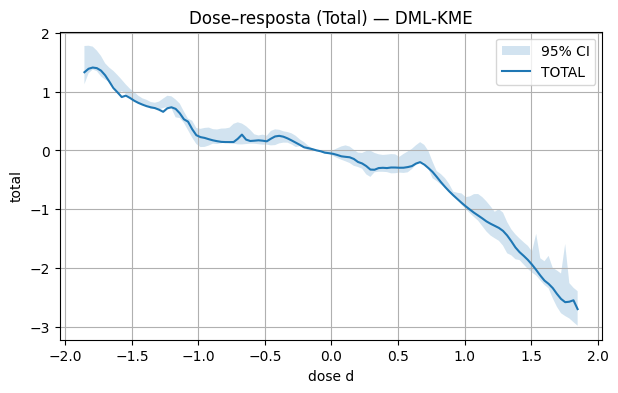

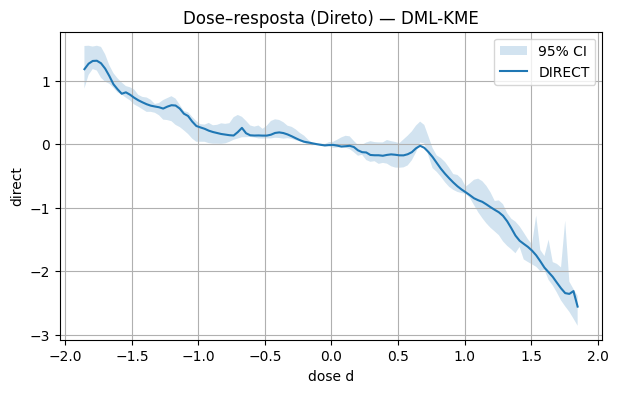

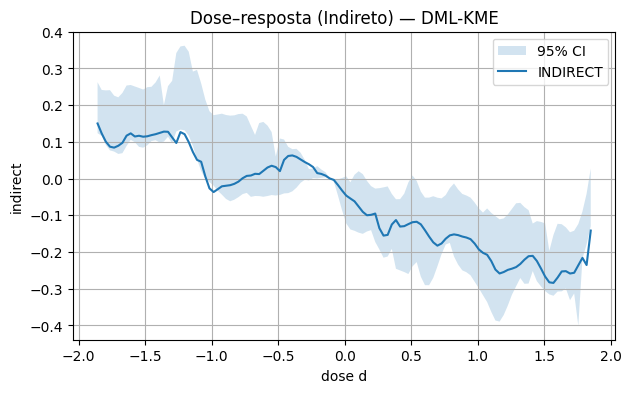

In [11]:
# est já ajustado:
# df_curve = estimate_curve(est, T,M,X,Y, d_grid, d_prime)

# IC rápidos (bem mais leve): B menor já funciona
df_band = bootstrap_bands_fast(MODEL_TARGET, est_settings, T,M,X,Y, d_grid, d_prime, B=5, alpha=0.05)

# plota linha + faixa
def plot_curve_with_band(df_curve, df_band, ykey, title):
    x = df_curve["d"].values
    y = df_curve[ykey].values
    lo = df_band[f"{ykey}_lo"].values
    hi = df_band[f"{ykey}_hi"].values
    plt.figure(figsize=(7,4))
    plt.fill_between(x, lo, hi, alpha=0.2, label="95% CI")
    plt.plot(x, y, label=ykey.upper())
    plt.xlabel("dose d"); plt.ylabel(ykey); plt.title(title)
    plt.grid(True); plt.legend(); plt.show()

plot_curve_with_band(df_curve, df_band, "total",   "Dose–resposta (Total) — DML-KME")
plot_curve_with_band(df_curve, df_band, "direct",  "Dose–resposta (Direto) — DML-KME")
plot_curve_with_band(df_curve, df_band, "indirect","Dose–resposta (Indireto) — DML-KME")
